# PanNuke prediction visualisation

**This notebook demonstrates the predictions made by Hover-Net and Micronet models as well as their ensemble. Also training progress is visualised**

In this notebook we will:

- Compare ground truth annotation to prediction for Hover-Net, Micronet models and their ensemble
- Plot the training statistics summary

In `config.py` we provide the following ids for PanNuke cells type:
```
self.nuclei_type_dict = {
            'Neoplastic': 1, # ! Please ensure the matching ID is unique
            'Inflammatory': 2,
            'Connective': 3,
            'Dead': 4,
            'Epithelial': 5
        }
```

Hover-Net post processing util assigns the following overlay colors for ids (hover/misc/vis_utils.py):
```
0 - black (background)
1 - red
2 - green
3 - blue
4 - yellow
5 - orange
```

Therefore, the nuclei types are highlighted the following way:
```
Neoplastic - red
Inflammatory - green
Connective - blue
Dead - yellow
Epithelial - orange
```
The prediction is generated as (256, 256, 2) numpy arrays where the first channel us instance map and the second one is type map. The separate instances are decoded with unique ids in \[1,N\] range where N is the number of detected instances; 0 - denotes background. The types are denoted according to the values provided in the config. 

In [64]:
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import math
import os
import random
import re

Our experimental setup follows the one from the original paper. The creators of the PanNuke dataset divided it into 3 splits (as described on the official dataset page https://warwick.ac.uk/fac/sci/dcs/research/tia/data/pannuke):

- Training: Fold 1; Validation: Fold 2; Testing: Fold 3
- Training: Fold 2; Validation: Fold 1; Testing: Fold 3
- Training: Fold 3; Validation: Fold 2; Testing: Fold 1

The notebook allows inspecting the results by a particular split.

In [10]:
# The desired split, can be split1, split2 or split3
split = 'split1'

# The correspondence between splits, folds and output
inference_fold = {'split1':'fold3', 'split2':'fold3', 'split3':'fold1'}
output = {'split1':'output_split1', 'split2':'output_split2', 'split3':'output_split3'}

fold = inference_fold[split]

# Specify the folders containing visualised GT annotation and post-processed prediction
# This is the folders hierarchy we have on Cartesius
ground_truth_dir = '/home/ccurs011/PanNukeSN GT annotated/' + fold
prediction_dir_hv = '/home/ccurs011/HoverNet/hover_net/' + output[split] + '/v1.0/np_hv/_proc'
prediction_dir_mc = '/home/ccurs011/HoverNet/micronet/' + output[split] + '/v3.0/micronet/_proc'
prediction_dir_ensemble = '/home/ccurs011/Ensemble/EnsembleResults/' + fold
images_original_dir = '/home/ccurs011/PanNuke Inference/' + fold
images_sn_dir = '/home/ccurs011/PanNuke Inference SN/' + fold 

In [11]:
# To sort images by id
id_re = re.compile(r"fold\d_(\d+)\.[a-z]{3}$")

def file_id(name):
    match = id_re.match(os.path.basename(name))
    idx = int(match.groups()[0])
    return idx

In [14]:
# Check that GT and prediction folders contain equal number of images
gt_images = sorted(glob.glob(ground_truth_dir + '/*.png'), key=file_id)
prediction_images_hv = sorted(glob.glob(prediction_dir_hv + '/*.png'), key=file_id)
prediction_images_mc = sorted(glob.glob(prediction_dir_mc + '/*.png'), key=file_id)
assert len(gt_images) == len(prediction_images_hv)
assert len(prediction_images_mc) == len(prediction_images_hv)

In [15]:
# Set up an image index
N = len(gt_images)
examples_num = 5
# Obtain a random sample to inspect
indexes = random.sample(range(N), examples_num)
print(indexes)

[199, 995, 1513, 1818, 1007]


# Original images and images with applied stain-normalization

In [16]:
"""The function to plot the original image vs stain-normalized image
"""
def show_original_vs_sn_at(index, image_list_original, image_list_sn):
    img_original = cv2.imread(image_list_original[index])
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original_name = os.path.basename(image_list_original[index])
    
    img_sn = cv2.imread(image_list_sn[index])
    img_sn = cv2.cvtColor(img_sn, cv2.COLOR_BGR2RGB)
    img_sn_name = os.path.basename(image_list_sn[index])

    plt.figure(figsize=(9,9))
    
    plt.subplot(1,2,1)
    plt.imshow(img_original)
    plt.axis('off')
    plt.title('Original {}'.format(img_original_name))
    
    plt.subplot(1,2,2)
    plt.imshow(img_sn)
    plt.axis('off')
    plt.title('Stain normalized {}'.format(img_sn_name))

    plt.show()

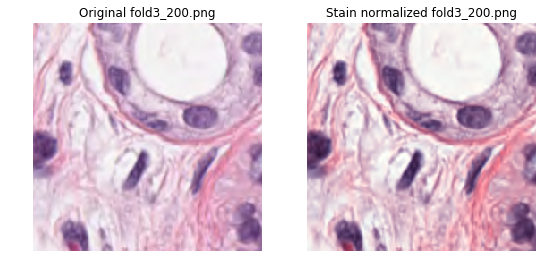

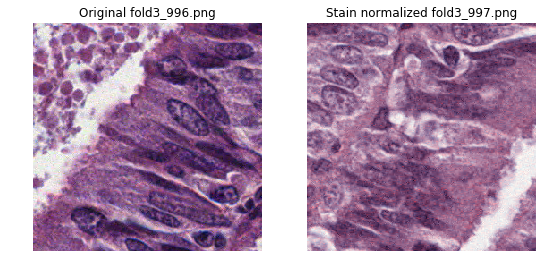

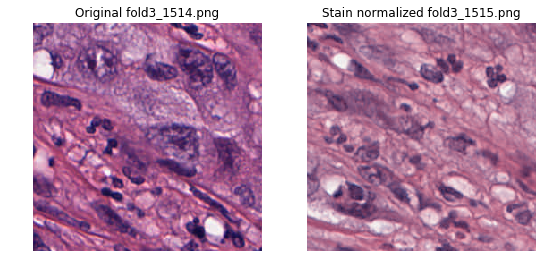

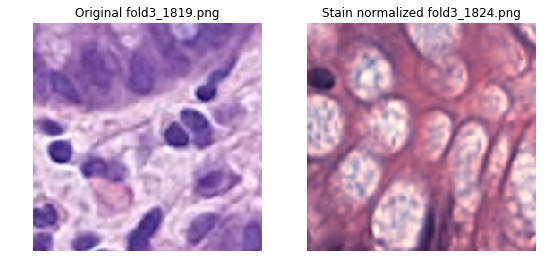

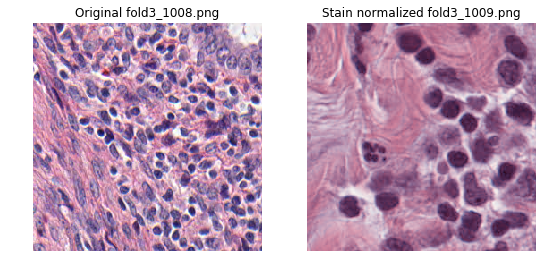

In [17]:
# Compare images from a sample to it's stain-normalized version
image_list_original = sorted(glob.glob(images_original_dir + '/*'), key=file_id)
image_list_sn = sorted(glob.glob(images_sn_dir + '/*'), key=file_id) 
for i in indexes:
    show_original_vs_sn_at(i, image_list_original, image_list_sn)

In [18]:
"""Loads the image with prediction visualised as overlays of different colors
"""
def prediction_overlay_at(index, overlay_list):
    overlay = cv2.imread(overlay_list[index]) # read the first file
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB) # cv2 reads as BGR -> convert back to RGB
    return overlay

"""Loads types and instances maps for an image
"""
def prediction_map_at(index, numpy_list, inst_map_ind=0, type_map_ind=1):
    numpy_file = np.load(numpy_list[index]) # read the first file

    # the numpy file is a HxWx2 size array, where H and W are the height and width of the original image. 
    # The first channel is the instance segmentation results and the second channel is the classification results.
    # Now let's plot each of the channels - 1st channel = instance map, 2nd channel = type map

    inst_map = numpy_file[...,inst_map_ind]
    type_map = numpy_file[...,type_map_ind]
    return inst_map, type_map

In [19]:
"""Plots the stain-normalized image next to its prediction expessed with overlay, instance map and type map
"""
def plot_segmentation(image, overlay, inst_map, type_map):
    plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Patch')
    
    plt.subplot(1,4,2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Overlay')
    
    plt.subplot(1,4,3)
    plt.imshow(inst_map)
    plt.axis('off')
    plt.title('Instance Map')

    plt.subplot(1,4,4)
    plt.imshow(type_map)
    plt.axis('off')
    plt.title('Type Map')

    plt.show()

# Plot predictions vs ground truth
See the explanation of overlay colors, instance and type maps at the begining of the notebook

In [20]:
# Ground truth
# get a list of the overlaid results in the ground truth directory
gt_overlay_list = sorted(glob.glob(ground_truth_dir + '/*.png'), key=file_id)
# get a list of the numpy results in the ground truth directory
gt_numpy_list = sorted(glob.glob(ground_truth_dir + '/*.npy'), key=file_id)

# HoverNet
# get a list of the overlaid results in the prediction directory
hv_overlay_list = sorted(glob.glob(prediction_dir_hv + '/*.png'), key=file_id)
# get a list of the numpy results in the prediction directory
hv_numpy_list = sorted(glob.glob(prediction_dir_hv + '/*.npy'), key=file_id)

# Micronet
# get a list of the overlaid results in the prediction directory
mc_overlay_list = sorted(glob.glob(prediction_dir_mc + '/*.png'), key=file_id)
# get a list of the numpy results in the prediction directory
mc_numpy_list = sorted(glob.glob(prediction_dir_mc + '/*.npy'), key=file_id)

In [47]:
"""Plots predictions from different models for images at indexes
"""
def visualise_prediction(indexes, image_list, gt_overlay_list, hv_overlay_list, mc_overlay_list):
    for index in indexes:
        img_name = image_list[index]
        print("Image {}:".format(os.path.basename(img_name)))
        
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get ground truth data for an image at index 
        gt_overlay_image = prediction_overlay_at(index, gt_overlay_list)
        gt_inst_map, gt_type_map = prediction_map_at(index, gt_numpy_list, 3, 4)

        # Get HoverNet prediction data for an image at index
        hv_pred_overlay_image = prediction_overlay_at(index, hv_overlay_list)
        hv_pred_inst_map, hv_pred_type_map = prediction_map_at(index, hv_numpy_list)

        # Get Micronet prediction data for an image at index
        mc_pred_overlay_image = prediction_overlay_at(index, mc_overlay_list)
        mc_pred_inst_map, mc_pred_type_map = prediction_map_at(index, mc_numpy_list)

        # Show ground truth segmentation
        print("Ground truth")
        plot_segmentation(img, gt_overlay_image, gt_inst_map, gt_type_map)
        # Show segmentation predicted by HoverNet
        print("Prediction HoverNet")
        plot_segmentation(img, hv_pred_overlay_image, hv_pred_inst_map, hv_pred_type_map)
        # Show segmentation predicted by Micronet
        print("Prediction Micronet")
        plot_segmentation(img, mc_pred_overlay_image, mc_pred_inst_map, mc_pred_type_map)

Image fold3_200.png:
Ground truth


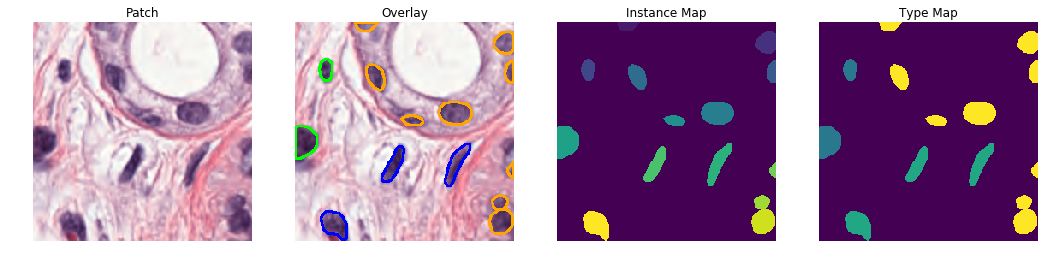

Prediction HoverNet


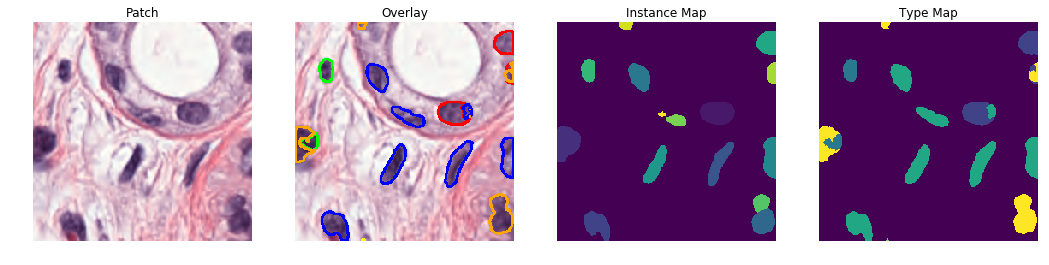

Prediction Micronet


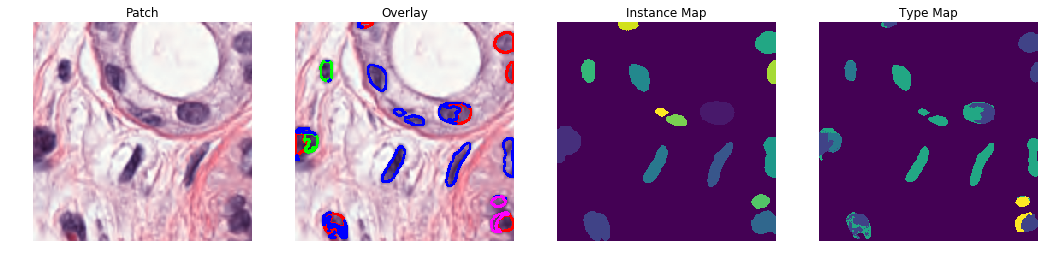

Image fold3_997.png:
Ground truth


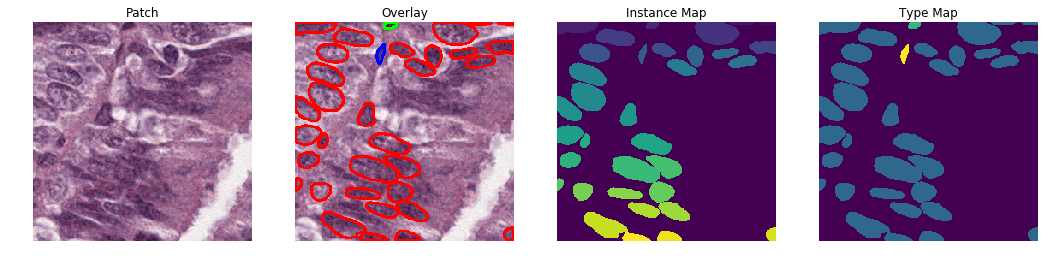

Prediction HoverNet


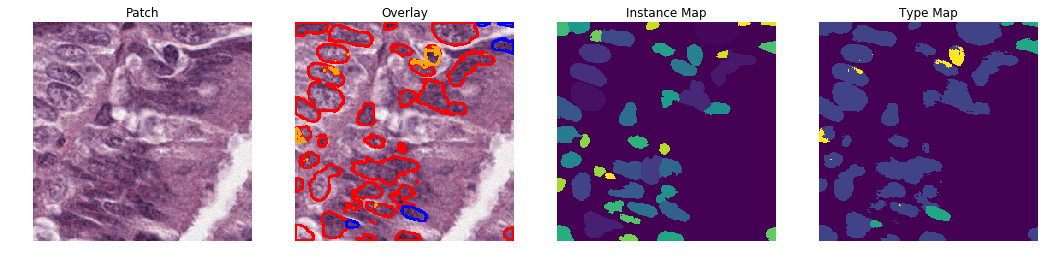

Prediction Micronet


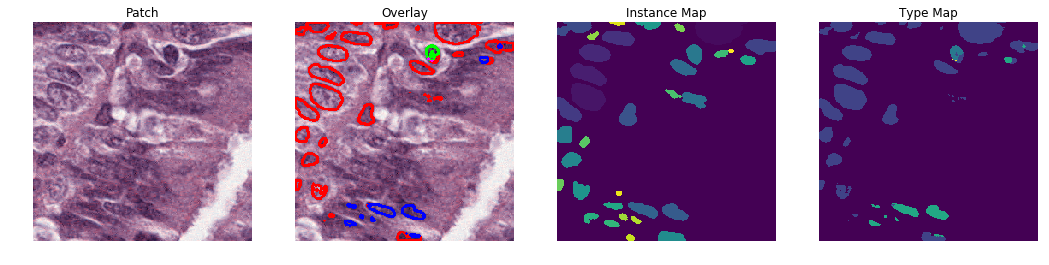

Image fold3_1515.png:
Ground truth


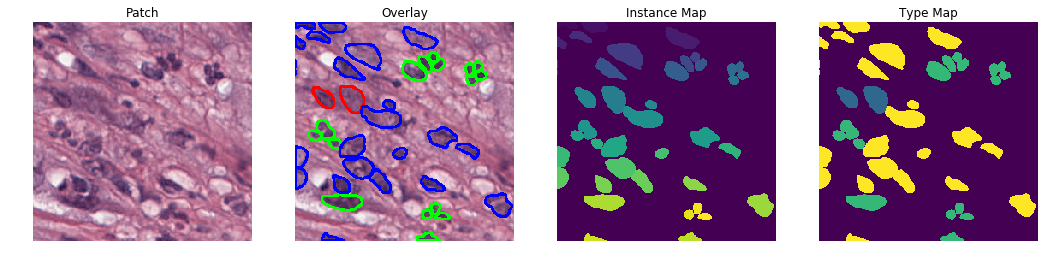

Prediction HoverNet


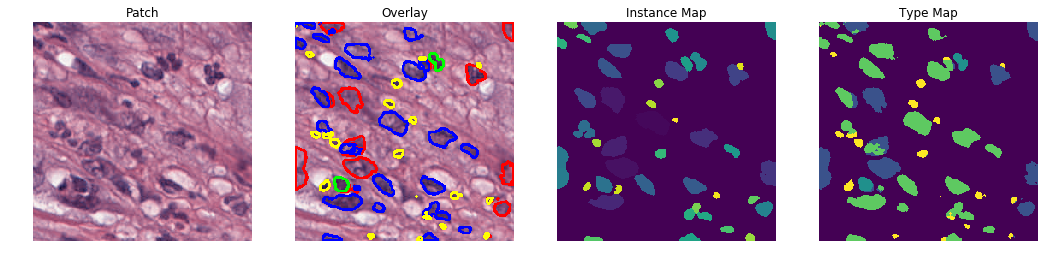

Prediction Micronet


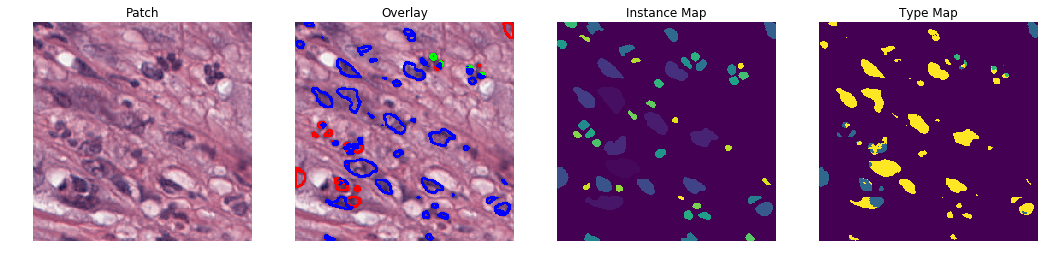

Image fold3_1824.png:
Ground truth


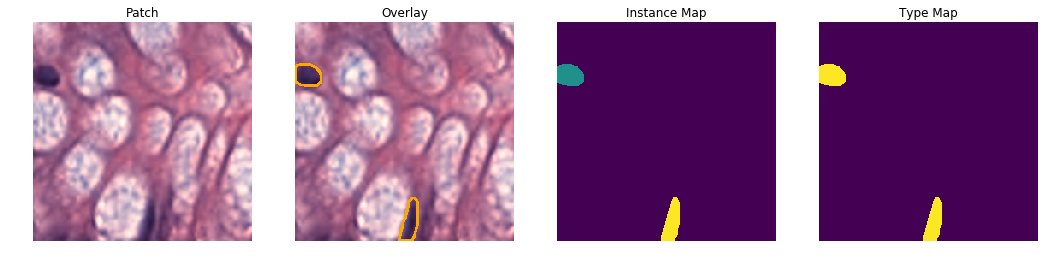

Prediction HoverNet


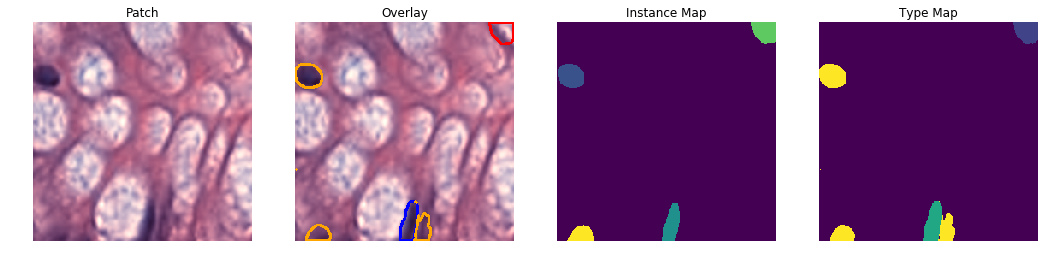

Prediction Micronet


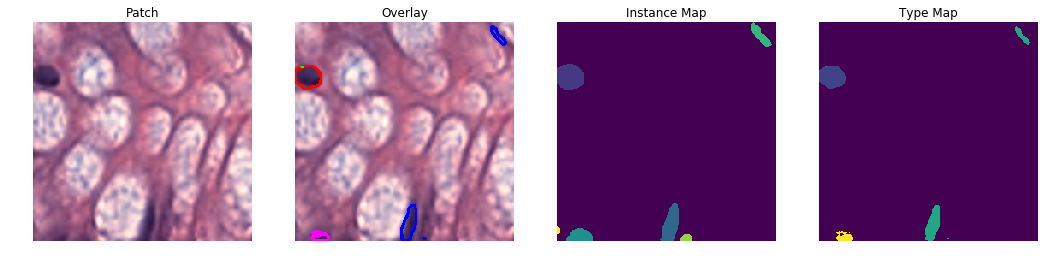

Image fold3_1009.png:
Ground truth


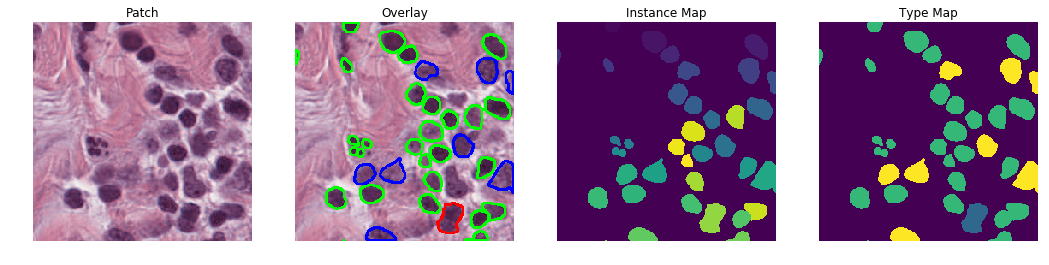

Prediction HoverNet


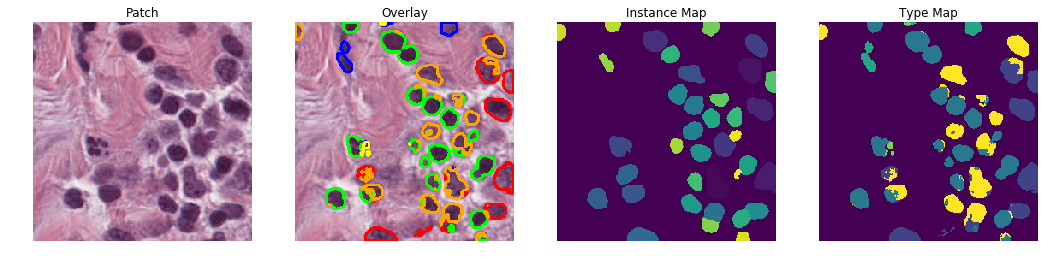

Prediction Micronet


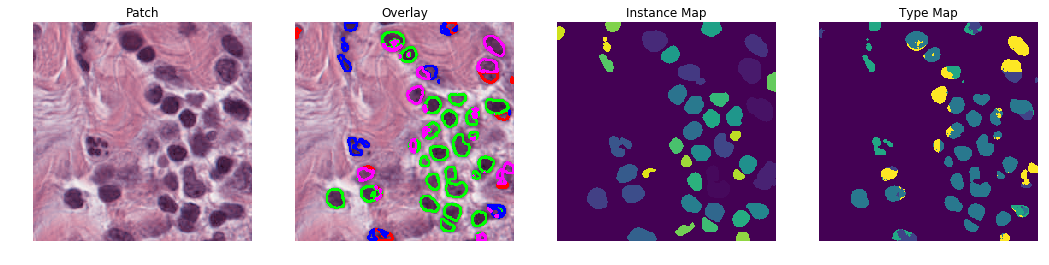

In [48]:
visualise_prediction(indexes, image_list_sn, gt_overlay_list, hv_overlay_list, mc_overlay_list)

# Prediction by selected tissue type

In [49]:
# With stain normalization we lost a few images in each fold. 
# We need to take it into account while extracting images by tissue type
missed_ids1 = [1723, 1939, 1940, 1946, 1969, 1973, 1977, 1978, 1979, 2009, 2020, 2022]
missed_ids2 = [1471, 1472, 1543, 1607, 1651, 1653, 1661, 1662, 1685, 1686, 1687, 1688, 1692, 1694, 1702, 1889]
missed_ids3 = [762, 1566, 1569, 1777, 1804, 1834, 1837, 1838, 1839, 1840, 1841, 1854, 1855, 1856, 1860, 1861, 1862, 1897, 2023]
missed_in_split = {"split1":missed_ids3, "split2":missed_ids3, "split3":missed_ids1}

In [50]:
tissue_types = ['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix', 'Colon', 'Esophagus', 
                'HeadNeck', 'Kidney', 'Liver', 'Lung', 'None', 'Ovarian', 'Pancreatic', 'Prostate',
                'Skin', 'Stomach', 'Testis', 'Thyroid', 'Uterus']
tissue = "HeadNeck"
sample_size = 10

In [51]:
# For convenience the types are saved inside notebook folder
types_path = "types/"+ split + "/types.npy"

In [52]:
"""Creates a dictionary with indexes for each tissue type
"""
def indicies_by_type(types_path, missed_ids):
    types = np.load(types_path)
    types[missed_ids] = "None"
    
    unique_types = np.unique(types)
    print(unique_types)

    types_idxs = {}

    for tp in unique_types:
        if tp != "None":
            indices = [i for i, x in enumerate(types) if x == tp]
            types_idxs[tp] = indices
    
    return types_idxs

"""Sample images ids for a given tissue type
"""
def sample_tissue(types_idxs, tissue, sample_size):
    tissue_idxs = types_idxs[tissue]
    return tissue_idxs if len(tissue_idxs) < sample_size else random.sample(tissue_idxs, sample_size)

In [53]:
types_idxs = indicies_by_type(types_path, missed_in_split[split])
sample = sample_tissue(types_idxs, tissue, sample_size)

['Adrenal_gland' 'Bile-duct' 'Bladder' 'Breast' 'Cervix' 'Colon'
 'Esophagus' 'HeadNeck' 'Kidney' 'Liver' 'Lung' 'None' 'Ovarian'
 'Pancreatic' 'Prostate' 'Skin' 'Stomach' 'Testis' 'Thyroid' 'Uterus']


HeadNeck
Image fold3_2086.png:
Ground truth


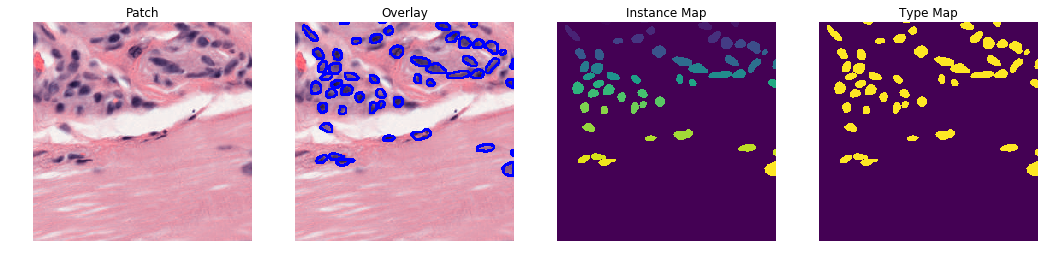

Prediction HoverNet


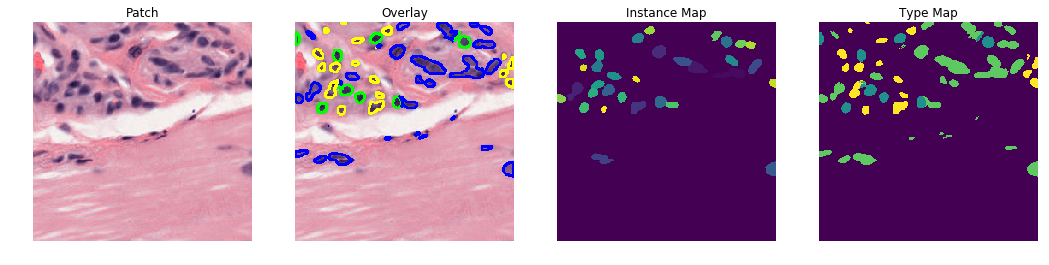

Prediction Micronet


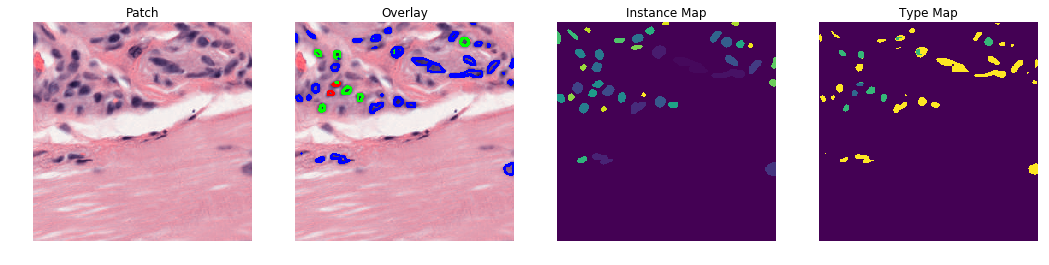

Image fold3_2067.png:
Ground truth


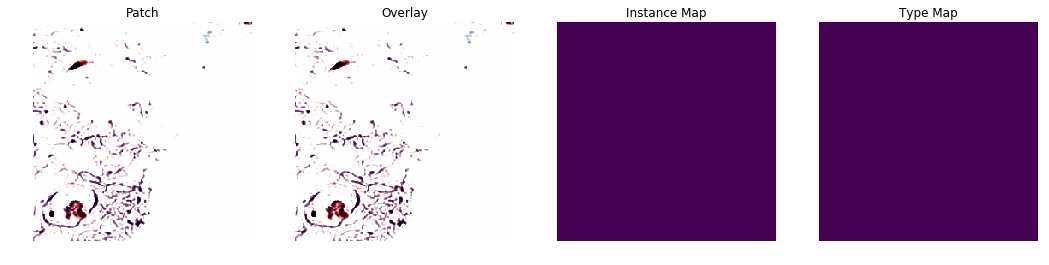

Prediction HoverNet


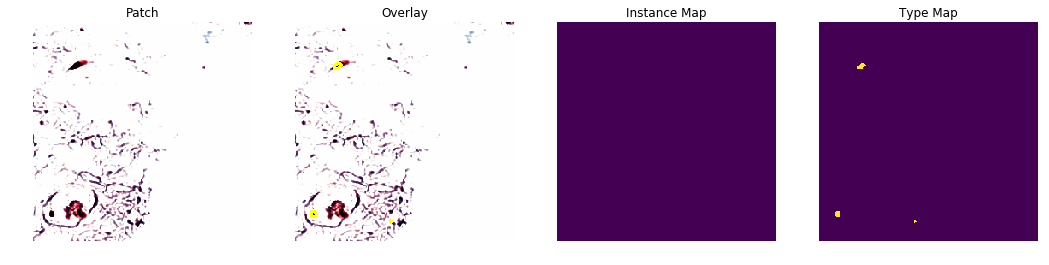

Prediction Micronet


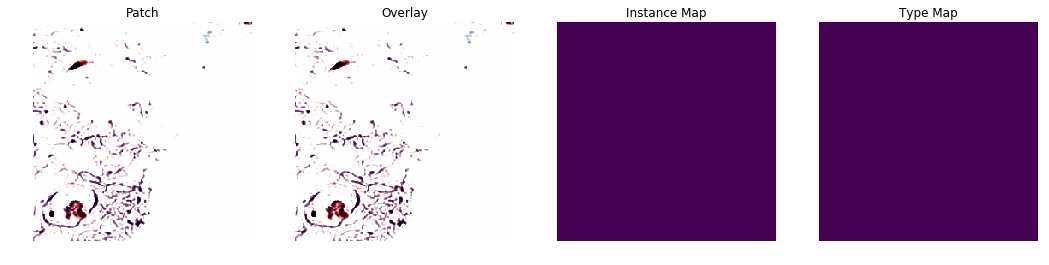

Image fold3_2092.png:
Ground truth


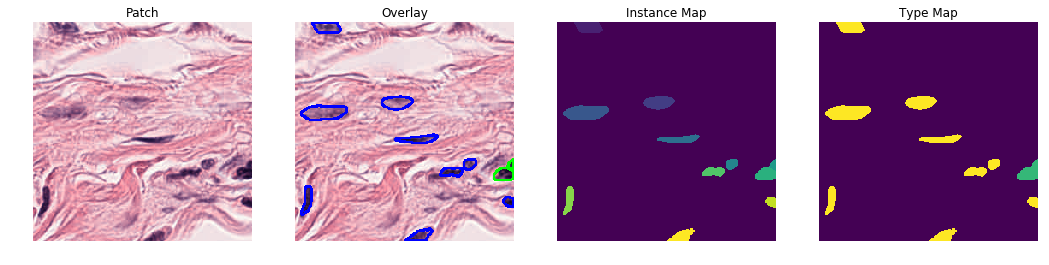

Prediction HoverNet


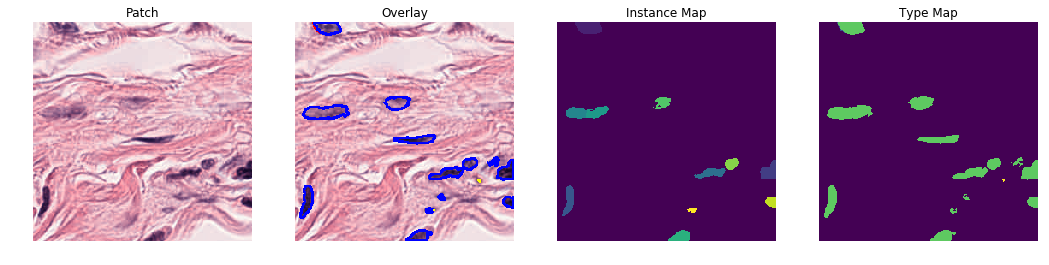

Prediction Micronet


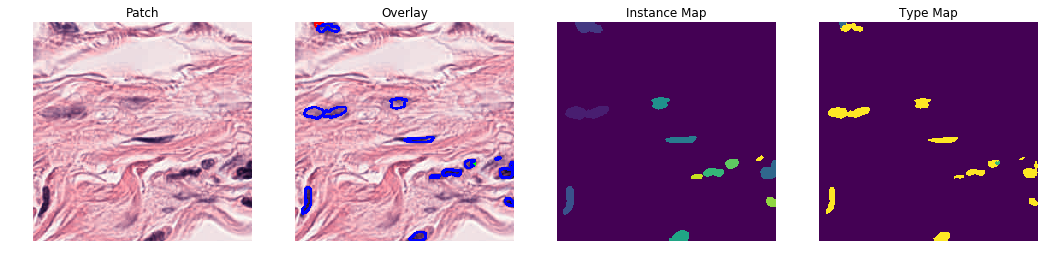

Image fold3_2115.png:
Ground truth


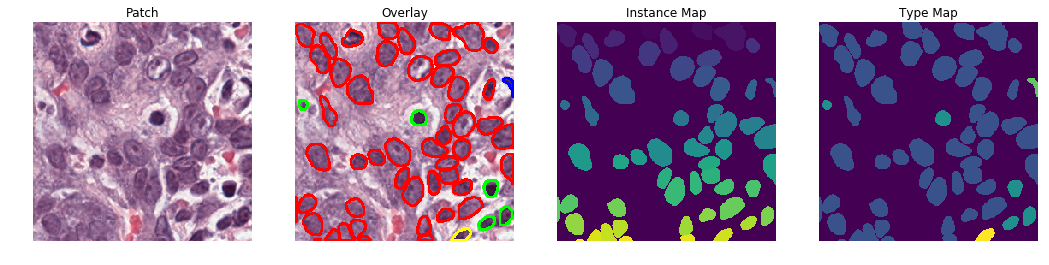

Prediction HoverNet


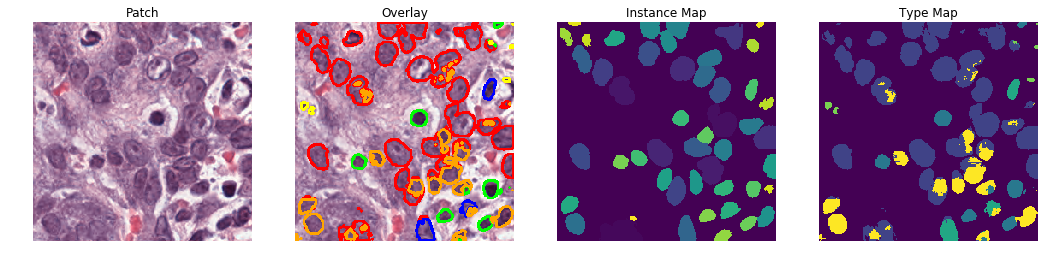

Prediction Micronet


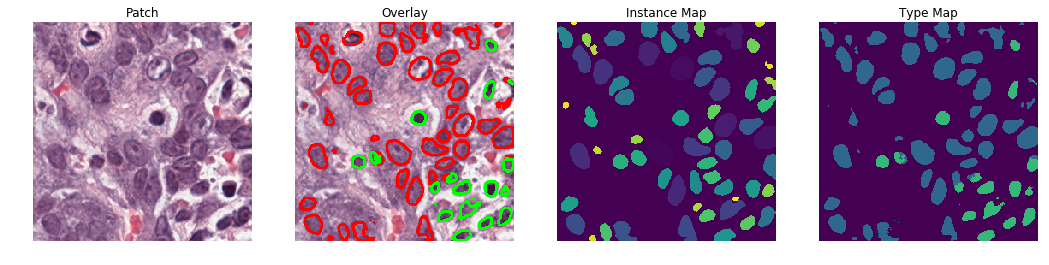

Image fold3_2090.png:
Ground truth


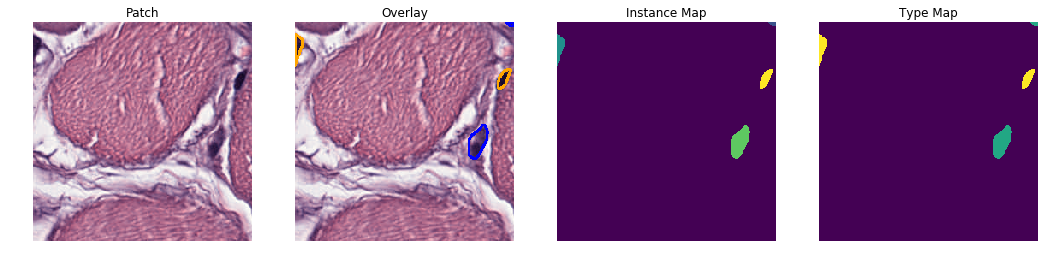

Prediction HoverNet


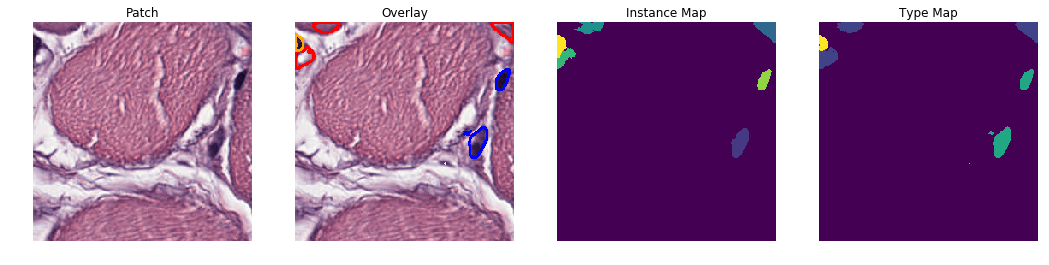

Prediction Micronet


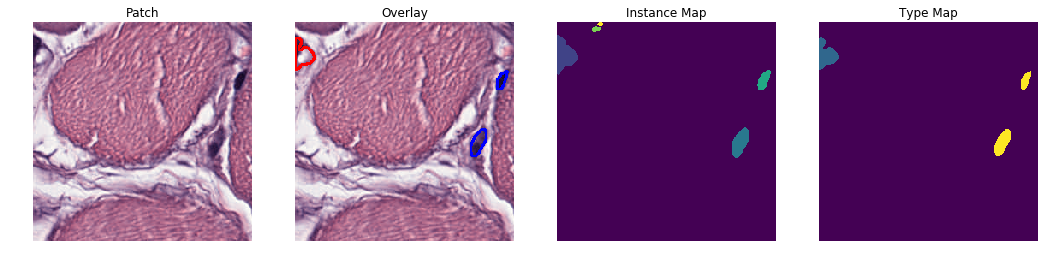

Image fold3_2107.png:
Ground truth


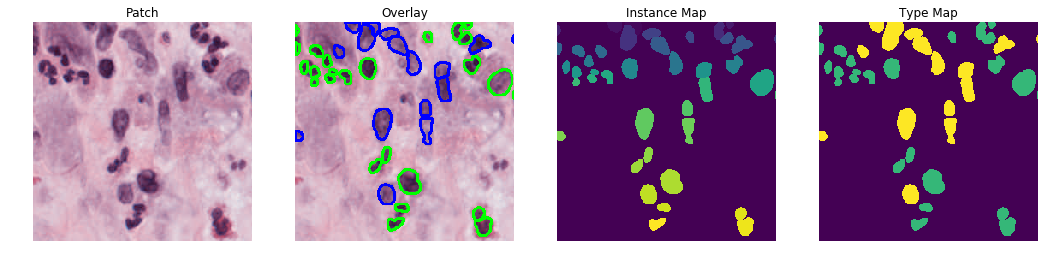

Prediction HoverNet


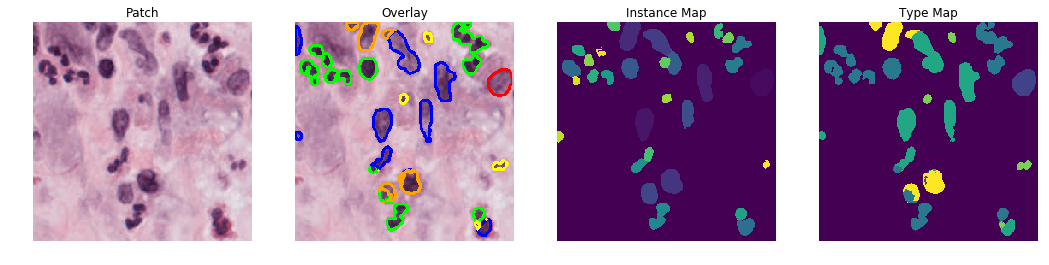

Prediction Micronet


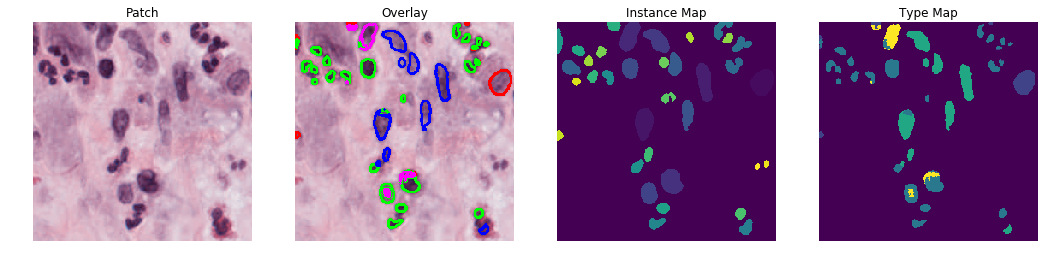

Image fold3_2055.png:
Ground truth


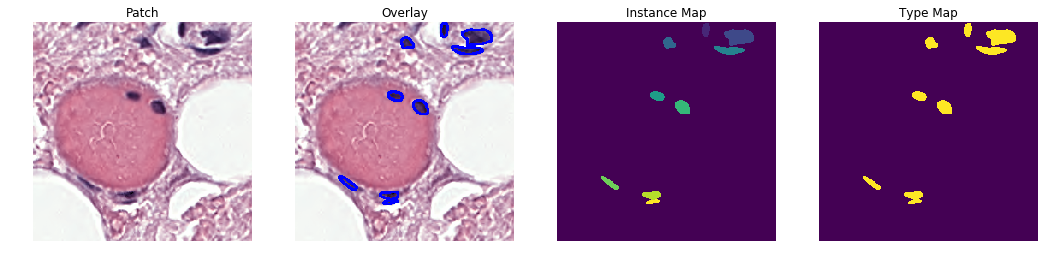

Prediction HoverNet


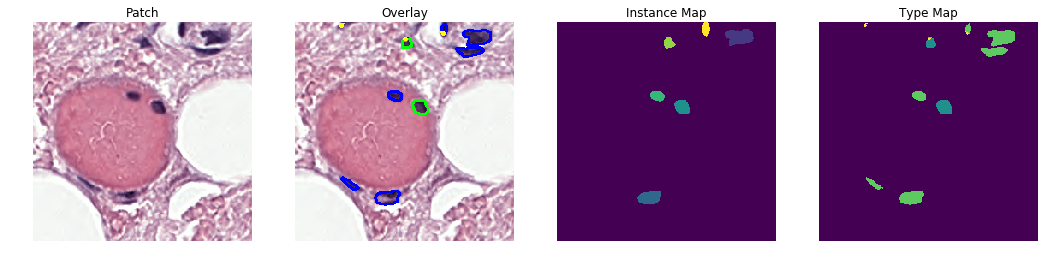

Prediction Micronet


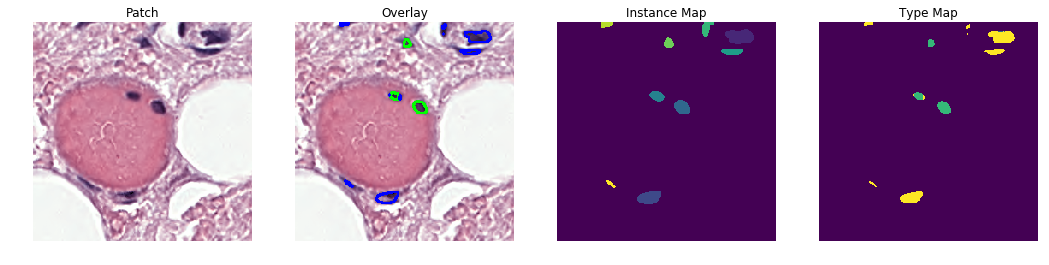

Image fold3_2044.png:
Ground truth


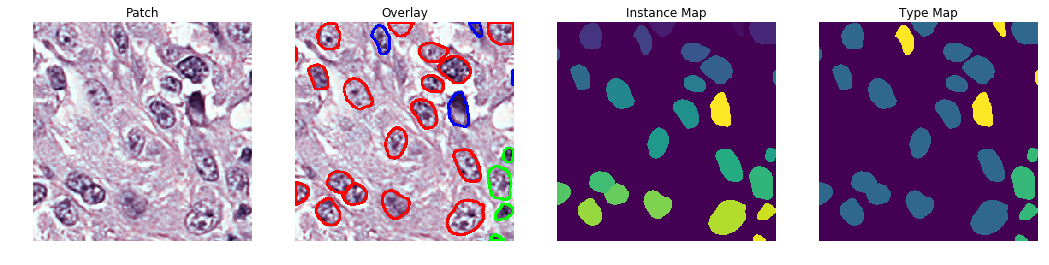

Prediction HoverNet


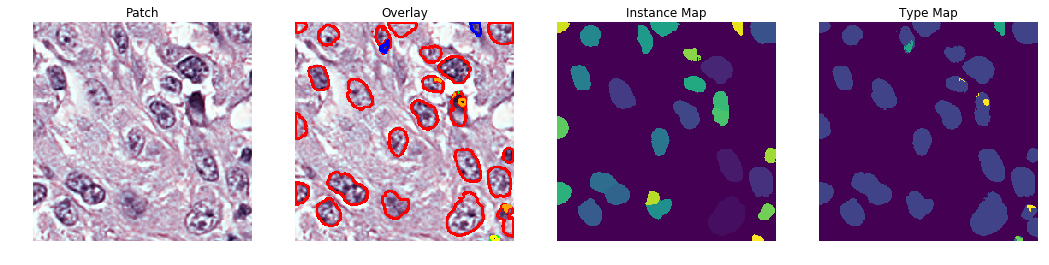

Prediction Micronet


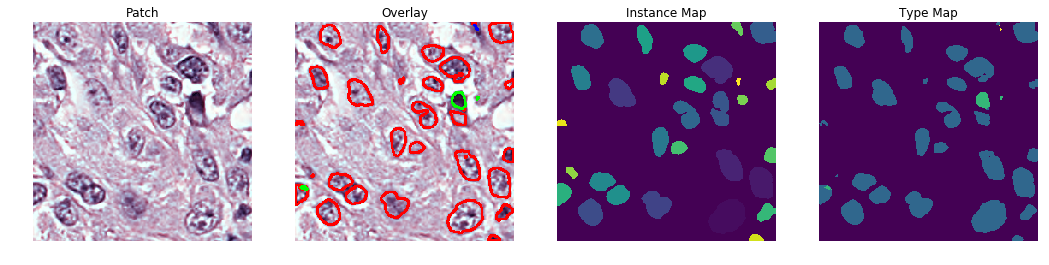

Image fold3_2009.png:
Ground truth


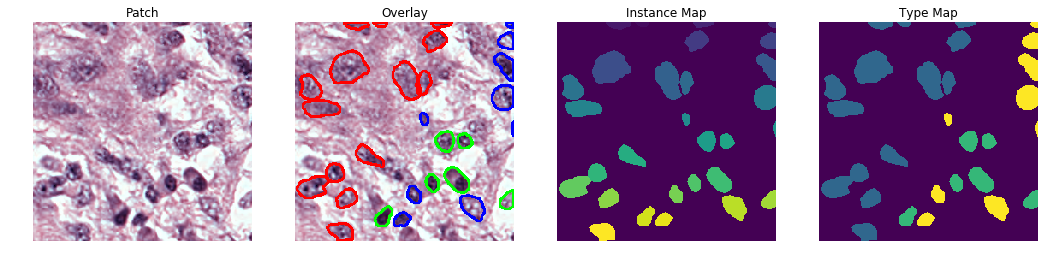

Prediction HoverNet


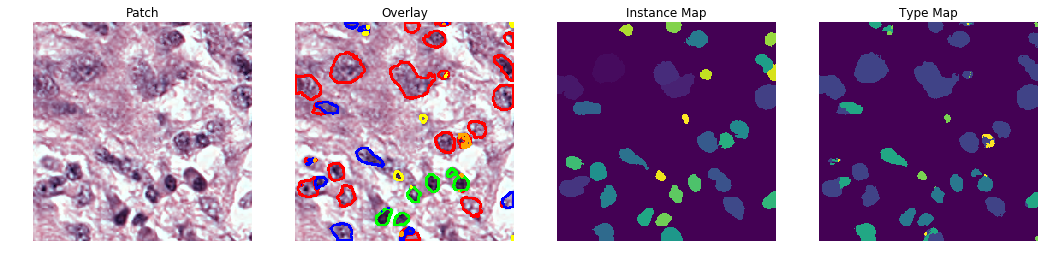

Prediction Micronet


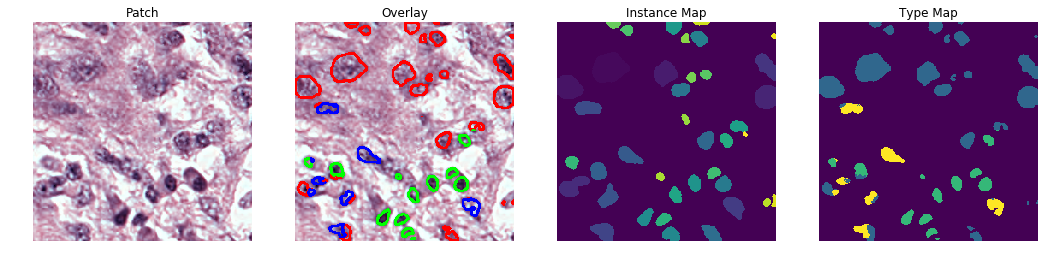

Image fold3_2109.png:
Ground truth


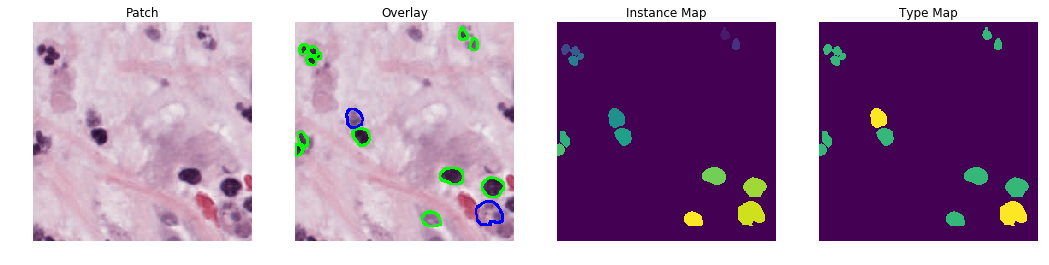

Prediction HoverNet


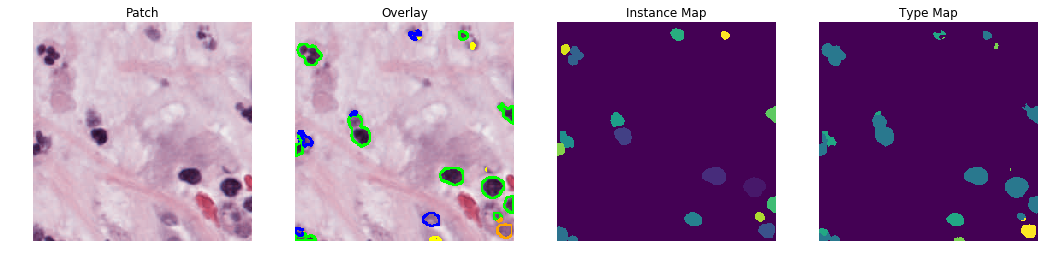

Prediction Micronet


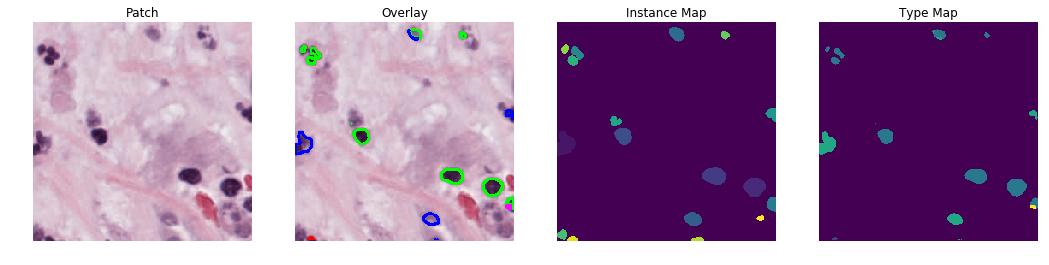

In [54]:
print("{}".format(tissue))
visualise_prediction(sample, image_list_sn, gt_overlay_list, hv_overlay_list, mc_overlay_list)

# Prediction example by each tissue type

In [37]:
example_size = 2

In [ ]:
for tissue in tissue_types:
    if tissue != "None":
        print("{}".format(tissue))
        sample = sample_tissue(types_idxs, tissue, example_size)
        visualise_prediction(sample, image_list_sn, gt_overlay_list, hv_overlay_list, mc_overlay_list)

# Statistics visualisation

For convenience training statistics is copied to notebook folder.

In [55]:
import json

def extract_train_stat(stat_file_path):
    lr_stat = []
    # Training stat
    overall_loss_stat = []
    loss_bce_stat = []
    loss_dice_stat = []
    # Validation stat
    valid_mse_stat = []
    valid_acc_stat = []
    valid_dice_stat = []
    # Statistics by nuclei type
    # Neoplastic
    valid_dice_neo_stat = []
    # Inflammatory
    valid_dice_inf_stat = []
    # Connective
    valid_dice_con_stat = []
    # Dead
    valid_dice_dead_stat = []
    # Epithelial
    valid_dice_epi_stat = []
    
    with open(stat_file_path) as json_file:
        statistics = json.load(json_file)
    
    for epoch in statistics:
        lr_stat.append(epoch["learning_rate"])

        overall_loss_stat.append(epoch["overall-loss"])
        loss_bce_stat.append(epoch["loss-bce"])
        loss_dice_stat.append(epoch["loss-dice"])

        valid_mse_stat.append(epoch["valid_mse"])
        valid_acc_stat.append(epoch["valid_acc"])
        valid_dice_stat.append(epoch["valid_dice"])

        valid_dice_neo_stat.append(epoch["valid_dice_Neoplastic"])
        valid_dice_inf_stat.append(epoch["valid_dice_Inflammatory"])
        valid_dice_con_stat.append(epoch["valid_dice_Connective"])
        valid_dice_dead_stat.append(epoch["valid_dice_Dead"])
        valid_dice_epi_stat.append(epoch["valid_dice_Epithelial"])
    
    return {"lr": lr_stat, 
           "overall-loss": overall_loss_stat,
           "loss-bce": loss_bce_stat,
           "loss-dice": loss_dice_stat,
           "valid_mse": valid_mse_stat,
           "valid_acc": valid_acc_stat,
           "valid_dice": valid_dice_stat,
           "valid_dice_Neoplastic": valid_dice_neo_stat,
           "valid_dice_Inflammatory": valid_dice_inf_stat,
           "valid_dice_Connective": valid_dice_con_stat,
           "valid_dice_Dead": valid_dice_dead_stat,
           "valid_dice_Epithelial": valid_dice_epi_stat}

def extract_train_stat_mc(stat_file_path):
    lr_stat = []
    # Training stat
    overall_cost_stat = []
    loss_bce_stat = []
    loss_l2_stat = []
    # Validation stat
    valid_acc_stat = []
    valid_dice_stat = []
    # Statistics by nuclei type
    # Neoplastic
    valid_dice_neo_stat = []
    # Inflammatory
    valid_dice_inf_stat = []
    # Connective
    valid_dice_con_stat = []
    # Dead
    valid_dice_dead_stat = []
    # Epithelial
    valid_dice_epi_stat = []
    
    with open(stat_file_path) as json_file:
        statistics = json.load(json_file)
    
    for epoch in statistics:
        lr_stat.append(epoch["learning_rate"])

        overall_cost_stat.append(epoch["overall_cost"])
        loss_bce_stat.append(epoch["loss-bce-0"])
        loss_l2_stat.append(epoch["l2_wd_loss"])

        valid_acc_stat.append(epoch["valid_acc"])
        valid_dice_stat.append(epoch["valid_dice"])

        valid_dice_neo_stat.append(epoch["valid_dice_Neoplastic"])
        valid_dice_inf_stat.append(epoch["valid_dice_Inflammatory"])
        valid_dice_con_stat.append(epoch["valid_dice_Connective"])
        valid_dice_dead_stat.append(epoch["valid_dice_Dead"])
        valid_dice_epi_stat.append(epoch["valid_dice_Epithelial"])
    
    return {"lr": lr_stat, 
           "overall_cost": overall_cost_stat,
           "loss-bce-0": loss_bce_stat,
           "l2_wd_loss": loss_l2_stat,
           "valid_acc": valid_acc_stat,
           "valid_dice": valid_dice_stat,
           "valid_dice_Neoplastic": valid_dice_neo_stat,
           "valid_dice_Inflammatory": valid_dice_inf_stat,
           "valid_dice_Connective": valid_dice_con_stat,
           "valid_dice_Dead": valid_dice_dead_stat,
           "valid_dice_Epithelial": valid_dice_epi_stat}

In [56]:
plots_folder = "statistics plots/"
    
try:
    os.mkdir(plots_folder)
except FileExistsError:
    pass

In [57]:
def plot_one_stat(stat, stat_name, folder, save_to_file = True):
    plt.figure()
    plt.plot(stat)
    plt.xlabel("Epochs")
    plt.ylabel(stat_name)
    if save_to_file:
        plt.savefig("{}{}.png".format(folder, stat_name))
    
    plt.show()

In [58]:
def plot_few_stats_row(stats, stat_names, shared_name, folder, save_to_file = True):
    assert(len(stats)==len(stat_names))
    fig, axs = plt.subplots(1, len(stats), figsize=(15, 5))
    
    for index, (stat, name) in enumerate(zip(stats, stat_names)):
        axs[index].plot(stat)
        axs[index].set_xlabel("Epochs")
        axs[index].set_ylabel(name)
            
    plt.tight_layout()
    if save_to_file:
            plt.savefig("{}{}.png".format(folder, shared_name))
    plt.show()

In [59]:
def plot_few_stats(stats, stat_names, shared_name, folder, save_to_file = True):
    assert(len(stats)==len(stat_names))
    plt.figure()
    
    for stat, name in zip(stats, stat_names):
        plt.plot(stat, label=name)
        plt.xlabel("Epochs")
    
    lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_to_file:
            plt.savefig("{}{}.png".format(folder, shared_name), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [60]:
def plot_stat(stat, plots_folder):
    # Plot learning rate changes
    plot_one_stat(stat["lr"], "Learning rate", plots_folder)
    
    # Plot training loss changes
    plot_few_stats_row([stat["overall-loss"], stat["loss-bce"], stat["loss-dice"]],
                       ["Overall loss", "BCE loss", "Dice loss"],
                       "Training loss",
                       plots_folder)
    
    # Plot validation metrics changes
    plot_few_stats_row([stat["valid_mse"], stat["valid_acc"], stat["valid_dice"]],
                       ["Validation MSE", "Validation accuracy", "Validation dice"],
                       "Validation metrics",
                       plots_folder)
    
    # Plot validation dice per nuclei changes
    nuclei_stats = [stat["valid_dice_Neoplastic"], 
                    stat["valid_dice_Inflammatory"], 
                    stat["valid_dice_Connective"], 
                    stat["valid_dice_Dead"], 
                    stat["valid_dice_Epithelial"]]
    nuclei_names = ["Validation dice Neoplastic", "Validation dice Inflammatory", "Validation dice Connective", 
                    "Validation dice Dead", "Validation dice Epithelial"]
    plot_few_stats(nuclei_stats, nuclei_names, "Nuclei validation dice", plots_folder)
    

def plot_stat_mc(stat, plots_folder):
    # Plot learning rate changes
    plot_one_stat(stat["lr"], "Learning rate", plots_folder)
    
    # Plot training loss changes
    plot_few_stats_row([stat["overall_cost"], stat["loss-bce-0"], stat["l2_wd_loss"]],
                       ["Overall cost", "BCE-0 loss", "L2 WD loss"],
                       "Training loss",
                       plots_folder)
    
    # Plot validation metrics changes
    plot_few_stats_row([stat["valid_acc"], stat["valid_dice"]],
                       ["Validation accuracy", "Validation dice"],
                       "Validation metrics",
                       plots_folder)
    
    # Plot validation dice per nuclei changes
    nuclei_stats = [stat["valid_dice_Neoplastic"], 
                    stat["valid_dice_Inflammatory"], 
                    stat["valid_dice_Connective"], 
                    stat["valid_dice_Dead"], 
                    stat["valid_dice_Epithelial"]]
    nuclei_names = ["Validation dice Neoplastic", "Validation dice Inflammatory", "Validation dice Connective", 
                    "Validation dice Dead", "Validation dice Epithelial"]
    plot_few_stats(nuclei_stats, nuclei_names, "Nuclei validation dice", plots_folder)

# Hovernet training phase 1
For each fold we managed to train hovernet in two phases. The first one consists of 50 epochs and starts with pre-trained weights, for the second one we only managed to train it for 9 epochs for each split. The statistics for phases is shown separately.

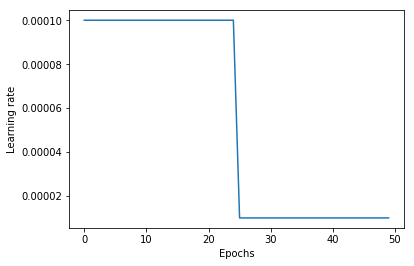

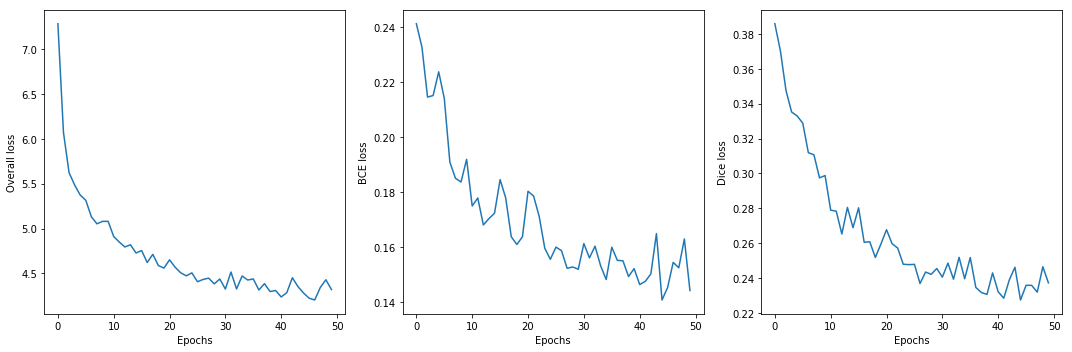

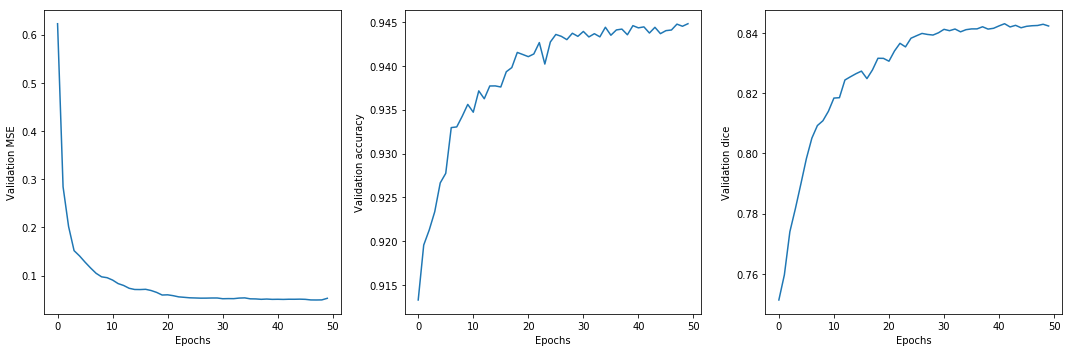

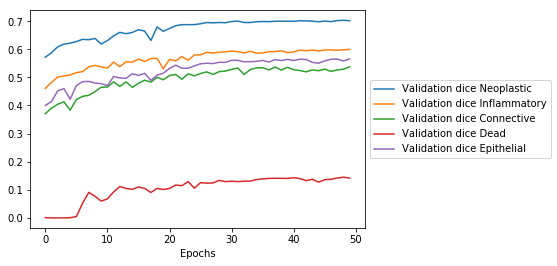

In [61]:
stat_file_path = "hovernet/" + split + "/stats1.json"
phase1_folder = plots_folder + "hovernet phase1/"

try:
    os.mkdir(phase1_folder)
except FileExistsError:
    pass

hover_phase1_stat = extract_train_stat(stat_file_path)
plot_stat(hover_phase1_stat, phase1_folder)

## Hovernet training phase 2

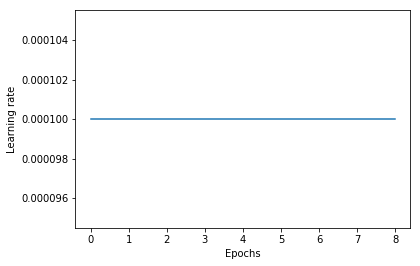

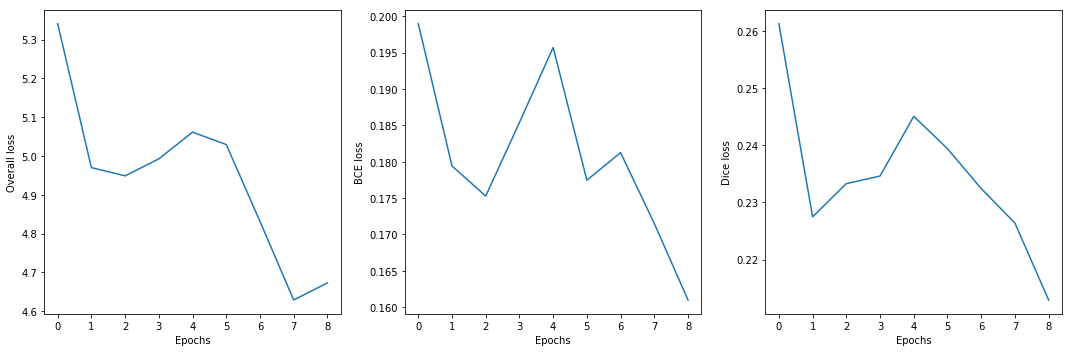

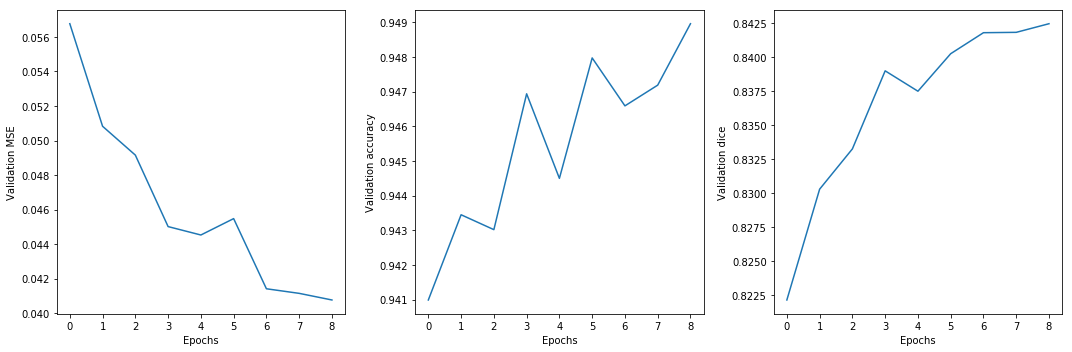

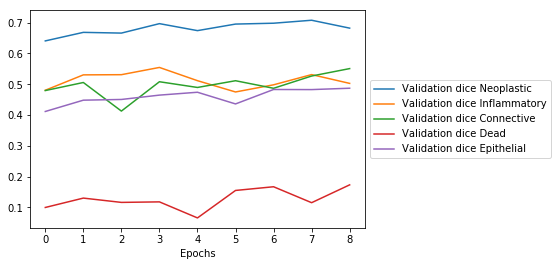

In [62]:
stat_file_path = "hovernet/" + split + "/stats2.json"
phase1_folder = plots_folder + "hovernet phase2/"

try:
    os.mkdir(phase1_folder)
except FileExistsError:
    pass

hover_phase1_stat = extract_train_stat(stat_file_path)
plot_stat(hover_phase1_stat, phase1_folder)

# Micronet training

Micronet model is much more complex that HoverNet and requred substantially more time to train (one epoch more that one hour). Due to this and delays with jobs launching on Cartesius, we managed to train Micronet for different number of models for different splits:

- split1: 34
- split2: 42
- split3: 32

For split1 and split3 we trained it in two phases by continue training from the best saved model. This explains the metrics drop in the middle of the plots.

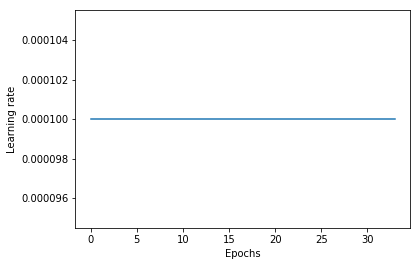

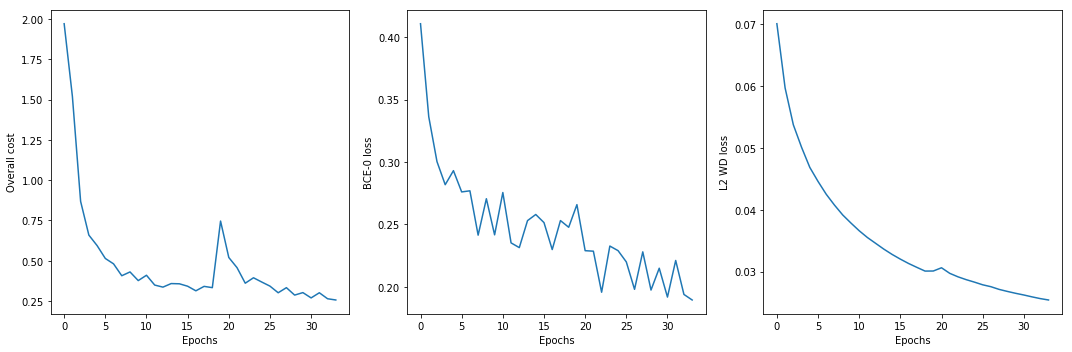

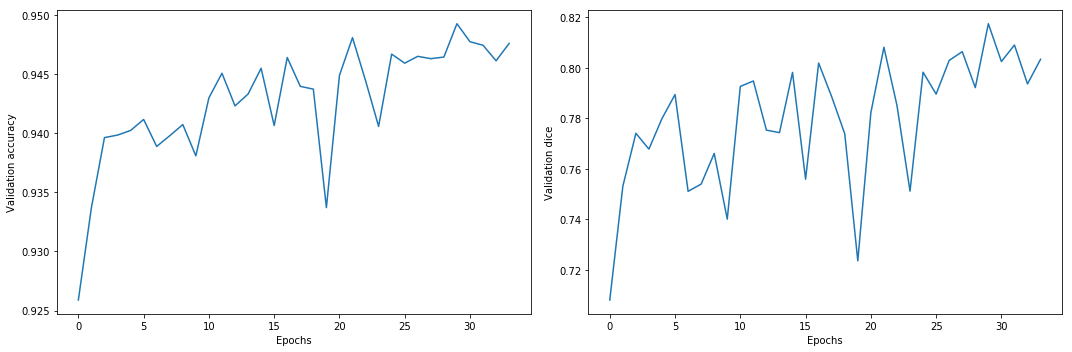

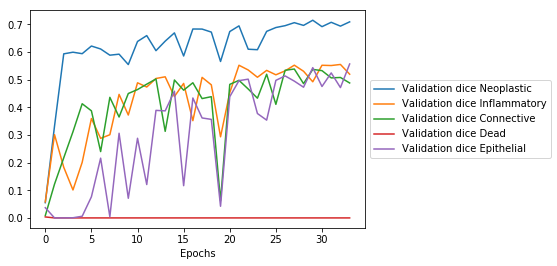

In [63]:
stat_file_path = "micronet/" + split + "/stats.json"
phase1_folder = plots_folder + "micronet/"

try:
    os.mkdir(phase1_folder)
except FileExistsError:
    pass

hover_phase1_stat = extract_train_stat_mc(stat_file_path)
plot_stat_mc(hover_phase1_stat, phase1_folder)